Loading necessary libraries

In [1]:
import sys
sys.path.append("..")
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import numpy as np

Disabling warnings for a clean preview. Comment the next block for the default state.

In [2]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = True

Necessary Variables

In [3]:
LOG_DIR = '../logs.nobidir/'
LOGS = []
ALL_DATA = {}
HIGH_QUALITY_IMAGES = False
image_format = 'eps'

In [4]:
font = {
    'weight': 'normal',
    'size': 16
}

mpl.rc('font', **font)

Here, we list the relevant log files from the training process

In [5]:
# Going through all files
for root, dirs, files in os.walk(LOG_DIR):
    for file in files:
        # Ignoring unnecessary results
        if root.find('logs') < 0:
            continue
        if not file.endswith('.v2'):
            continue
        if root.find('_level_') < 0:
            continue
        # Keeping the path to relevant files in memory
        LOGS.append(f'{root}/{file}')


Here we load the information within the log files into memory

In [6]:
# Loading the data from each relevant log file
for log in LOGS:
    ALL_DATA[log] = {'loss': [], 'accuracy': [], 'f1': [], 'auc_pr': [], 'start':None, 'end':None}
    for summary in summary_iterator(log):
        if not ALL_DATA[log]['start']:
            ALL_DATA[log]['start'] = float(summary.wall_time)
        ALL_DATA[log]['end'] = float(summary.wall_time)
        if len(summary.summary.value):
            if summary.summary.value[0].tag == 'epoch_loss':
                ALL_DATA[log]['loss'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_accuracy':
                ALL_DATA[log]['accuracy'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_f1':
                ALL_DATA[log]['f1'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_auc_pr':
                ALL_DATA[log]['auc_pr'].append(summary.summary.value[0].simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Some helper functions

In [7]:
# Function to load relevant data into a python array
def get_accuracy_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['accuracy'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['accuracy']], axis=0)
    return arr

def get_f1_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['f1'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['f1']], axis=0)
    return arr

def get_auc_pr_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['auc_pr'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['auc_pr']], axis=0)
    return arr

# Function to load relevant time data
def get_time_in_seconds(exp_keys, key_include):
    times = []
    for key in exp_keys:
        if key_include not in key:
            continue
        times.append(ALL_DATA[key]['end']-ALL_DATA[key]['start'])
    return times

# Function for creating accuracy per epoch plots
def plot_all_and_average_accuracy(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f} %'.format(x*100)))

    data_train = get_accuracy_data_numpy(exp_keys, 'train')
    data_valid = get_accuracy_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training Accuracy', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation Accuracy', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

# Function for creating f1 per epoch plots
def plot_all_and_average_f1(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('F1 Score')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    # ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f}'.format(x*100)))

    data_train = get_f1_data_numpy(exp_keys, 'train')
    data_valid = get_f1_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training F1 Score', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation F1 Score', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

# Function for creating AUC PR per epoch plots
def plot_all_and_average_auc_pr(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('AUC PR')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    # ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f}'.format(x*100)))

    data_train = get_auc_pr_data_numpy(exp_keys, 'train')
    data_valid = get_auc_pr_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training AUC PR', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation AUC PR', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

Creating Accuracy Per Epoch Plots for BLSTM Extended Experiments

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average Training Time: 1087.9148208141328, Average Validation Time: 1078.6159018039702


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


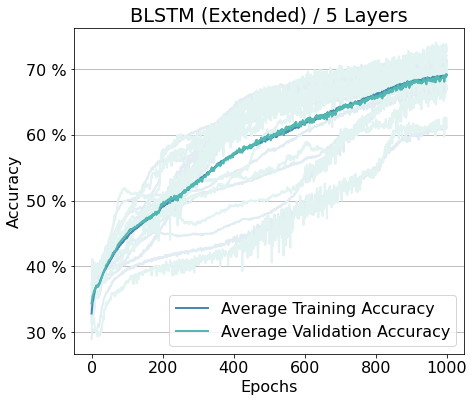

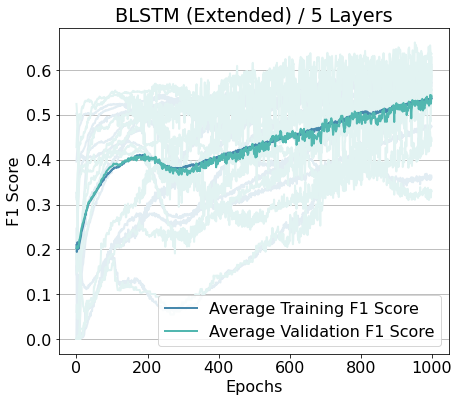

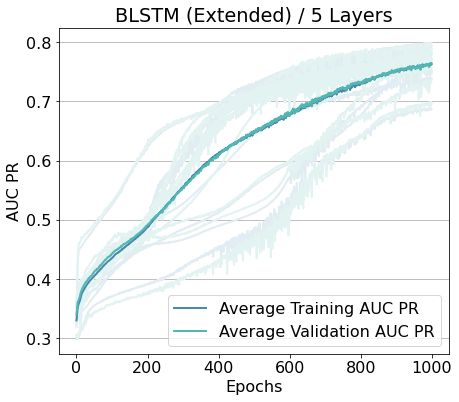

In [8]:
# BLSTM Extended Experiment 5

blstm5 = []
for key in ALL_DATA.keys():
    if 'blstm_level_5_extended/' in key:
        blstm5.append(key)
        
blstm5_train_time = np.mean(get_time_in_seconds(blstm5, 'train'))
blstm5_valid_time = np.mean(get_time_in_seconds(blstm5, 'valid'))
print(f'Average Training Time: {blstm5_train_time}, Average Validation Time: {blstm5_valid_time}')

plot_all_and_average_accuracy(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_acc.{image_format}')
plot_all_and_average_f1(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_auc_pr.{image_format}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average Training Time: 1169.4578376293182, Average Validation Time: 1159.4588465690613


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


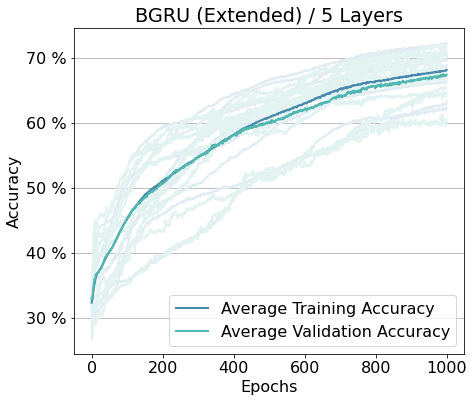

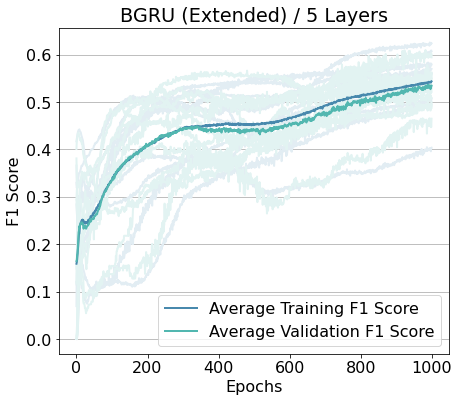

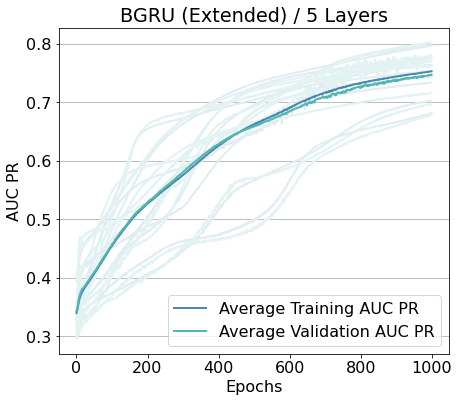

In [9]:
# BGRU Extended Experiment 5

bgru5 = []
for key in ALL_DATA.keys():
    if 'bgru_level_5_extended/' in key:
        bgru5.append(key)
        
gru5_train_time = np.mean(get_time_in_seconds(bgru5, 'train'))
gru5_valid_time = np.mean(get_time_in_seconds(bgru5, 'valid'))
print(f'Average Training Time: {gru5_train_time}, Average Validation Time: {gru5_valid_time}')

plot_all_and_average_accuracy(bgru5, 'BGRU (Extended) / 5 Layers', save=f'bgru5_ext_acc.{image_format}')
plot_all_and_average_f1(bgru5, 'BGRU (Extended) / 5 Layers', save=f'bgru5_ext_f1.{image_format}')
plot_all_and_average_auc_pr(bgru5, 'BGRU (Extended) / 5 Layers', save=f'bgru5_ext_auc_pr.{image_format}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average Training Time: 919.5136830687522, Average Validation Time: 912.1146919608116


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


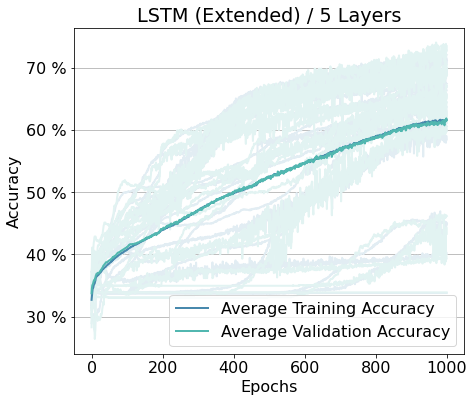

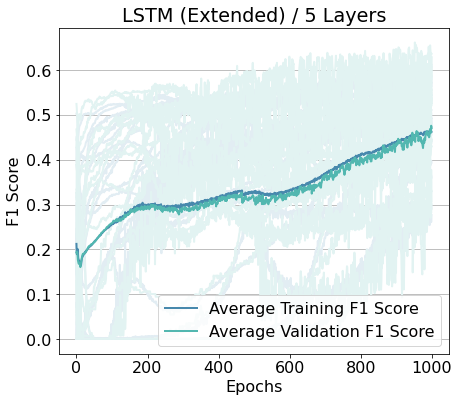

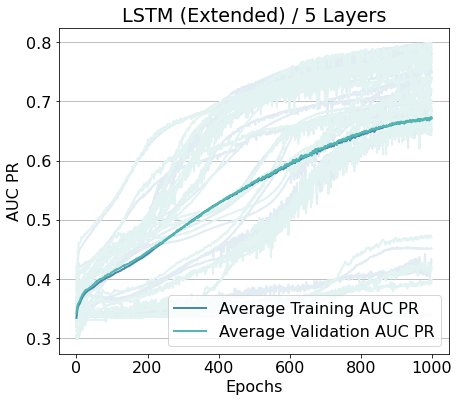

In [10]:
# LSTM Extended Experiment 5

lstm5 = []
for key in ALL_DATA.keys():
    if 'lstm_level_5_extended/' in key:
        lstm5.append(key)
        
lstm5_train_time = np.mean(get_time_in_seconds(lstm5, 'train'))
lstm5_valid_time = np.mean(get_time_in_seconds(lstm5, 'valid'))
print(f'Average Training Time: {lstm5_train_time}, Average Validation Time: {lstm5_valid_time}')

plot_all_and_average_accuracy(lstm5, 'LSTM (Extended) / 5 Layers', save=f'lstm5_ext_acc.{image_format}')
plot_all_and_average_f1(lstm5, 'LSTM (Extended) / 5 Layers', save=f'lstm5_ext_f1.{image_format}')
plot_all_and_average_auc_pr(lstm5, 'LSTM (Extended) / 5 Layers', save=f'lstm5_ext_auc_pr.{image_format}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average Training Time: 981.2844035625458, Average Validation Time: 973.435375225544


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


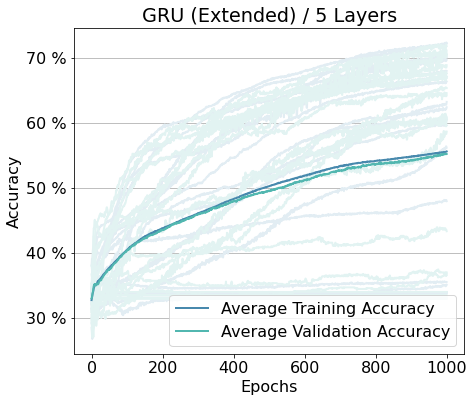

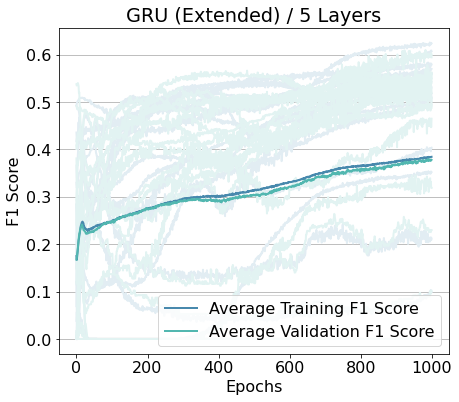

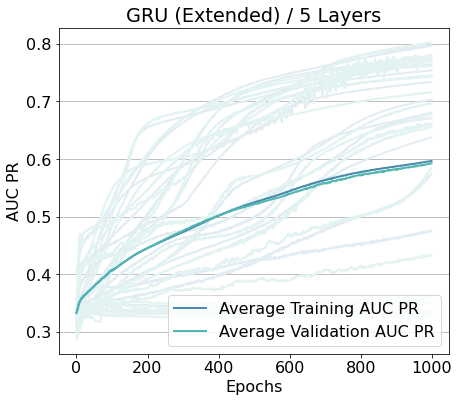

In [11]:
# GRU Extended Experiment 5

gru5 = []
for key in ALL_DATA.keys():
    if 'gru_level_5_extended/' in key:
        gru5.append(key)
        
gru5_train_time = np.mean(get_time_in_seconds(gru5, 'train'))
gru5_valid_time = np.mean(get_time_in_seconds(gru5, 'valid'))
print(f'Average Training Time: {gru5_train_time}, Average Validation Time: {gru5_valid_time}')

plot_all_and_average_accuracy(gru5, 'GRU (Extended) / 5 Layers', save=f'gru5_ext_acc.{image_format}')
plot_all_and_average_f1(gru5, 'GRU (Extended) / 5 Layers', save=f'gru5_ext_f1.{image_format}')
plot_all_and_average_auc_pr(gru5, 'GRU (Extended) / 5 Layers', save=f'gru5_ext_auc_pr.{image_format}')